### **PINN eikonal based velocity inversion for crosshole tomopgraph of the SEAM model**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io 
import time
import random
import os 
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable

device = 'cuda'
os.environ["CUDA_VISIBLE_DEVICES"]="0"
model_path = 'models4'
fig_path = 'figs4'
os.system(f'mkdir {model_path} {fig_path}')

0

In [2]:
#Model specifications

# Computational model parameters

zmin = -1; zmax = 7; deltaz_pred = 2
ymin = -25; ymax = 20; deltay_pred = 5
xmin = -25; xmax = 25; deltax_pred = 5

# load station location
sta_list = []
rx = []; ry = []; rz = []
stlo = []; stla = []; stel = []

with open('./station.car', 'r') as f:
    for line in f.readlines():
        part = line.split()
        sta_list.append(part[0])
        rx.append(float(part[1]))
        ry.append(float(part[2]))
        rz.append(float(part[3]))       ###### 

sta_list = np.array(sta_list)
rx = np.array(rx); ry = np.array(ry); rz = np.array(rz)
stlo = np.array(stlo); stla = np.array(stla); stel = np.array(stel)

nr = len(sta_list)
print(rx.shape)

# load event location
event_list = []
sx = []; sy = []; sz = []
evlo = []; evla = []; evdp = []

with open('./event.dat', 'r') as f:
    for line in f.readlines():
        part = line.split()
        event_list.append(int(part[0]))
        sx.append(float(part[4])/1000)
        sy.append(float(part[5])/1000)
        sz.append(float(part[6])/1000)       ###### 

event_list = np.array(event_list)
sx = np.array(sx); sy = np.array(sy); sz = np.array(sz)

ns = len(event_list)
print(sx.shape)



(53,)
(1000,)


In [3]:
# Creating grid, extending the velocity model, and prepare list of grid points for training (pred_grid)

## Grid for prediction
z_pred = np.arange(zmin, zmax+deltaz_pred, deltaz_pred)
nz_pred = z_pred.size

y_pred = np.arange(ymin, ymax+deltay_pred, deltay_pred)
ny_pred = y_pred.size

x_pred = np.arange(xmin, xmax+deltax_pred, deltax_pred)
nx_pred = x_pred.size

pred_Z, pred_Y, pred_X = np.meshgrid(z_pred, y_pred, x_pred, indexing='ij') 
print(pred_Z.shape)
pred_grid = np.array([pred_Z.reshape(-1), pred_Y.reshape(-1), pred_X.reshape(-1)])
pred_grid = pred_grid.transpose((1, 0))
# pred_grid = torch.from_numpy(pred_grid.astype(np.float32))
# print('pred_grid:', np.array(pred_grid).shape)

(5, 10, 11)


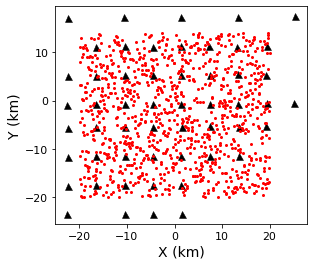

In [4]:
# Plot the velocity model with the source location

plt.style.use('default')

plt.figure(figsize=(4.5,4))

ax = plt.gca()
im = ax.plot(rx, ry, 'k^', markersize=7, markerfacecolor='k', markeredgewidth='0.5')
im = ax.plot(sx, sy, 'ro', markersize=2)

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=11)

# plt.gca().invert_yaxis()

ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.yaxis.set_major_locator(plt.MultipleLocator(10))

plt.savefig(f"./{fig_path}/v_true.pdf", format='pdf', bbox_inches="tight")

In [5]:
# create input and target data
# data points and boundary condition

v_init = 5.0

# print(vs, nr)
T0 = []
T_data = []
tau0 = []
data = []       ## rz, ry, rx, sz, sy, sx, pz, py, px, T0, tau, v, t
# sta_set = set()
with open('./absolute.dat', 'r') as f:
    for line in f.readlines():
        if line[0] == '#':
            items = line.split()
            evid = int(items[-1])
            if evid in event_list:
                index = np.where(event_list==evid)
                sx0 = sx[index][0]
                sy0 = sy[index][0]
                sz0 = sz[index][0]
                sv = v_init 
                # data.append([sz0, sy0, sx0, sz0, sy0, sx0, 0, 0, 0, 0, 1, sv, 0])
        else:
            sta, t, weight, phase = line.split()
            t = float(t)
            weight = float(weight)
            if (evid in event_list) and (sta in sta_list) and phase == 'P' and (weight==1):
                # sta_set.add(sta)
                index2 = np.where(sta_list==sta)
                rx0 = rx[index2][0]
                ry0 = ry[index2][0]
                rz0 = rz[index2][0]
                dist = ((rz0 - sz0)**2 + (ry0 - sy0)**2 + (rx0 - sx0)**2)**0.5
                T_data.append(t)
                T00 = dist/sv
                T0.append(T00)
                px0 = -(rx0 - sx0)/T00/sv**2
                py0 = -(ry0 - sy0)/T00/sv**2
                pz0 = -(rz0 - sz0)/T00/sv**2
                tau00 = t/T00
                tau0.append(tau00)
                data.append([sz0, sy0, sx0, rz0, ry0, rx0, pz0, py0, px0, T00, tau00, sv, t])
                # tmp = np.array([rz0, ry0, rx0, sz0, sy0, sx0, pz0, py0, px0, T00, tau00, sv, t])
                # if True in np.isnan(tmp):
                #     print(tmp)
            # else:
            #     sta_set.add(sta)


T0 = np.array([T0])
T_data = np.array([T_data])
tau0 = np.array([tau0])
data = np.array(data)
T0 = T0.transpose(1, 0)
T_data = T_data.transpose(1, 0)
tau0 = tau0.transpose(1, 0)
# data = data.transpose(1, 0)

print(T_data.shape, T0.shape, tau0.shape)
print(data.shape)      # 10*11*52: features, n_event, n_reveiver
# print(sta_set, len(sta_set))


(53000, 1) (53000, 1) (53000, 1)
(53000, 13)


In [6]:
# # select the stations with event number larger than 10
# i = 0
# sel_data = np.array([])
# sel_rx = []
# sel_ry = []
# sel_rz = []
# for i in range(nr):
#     part = data[np.where((data[:, 3]==rz[i])&(data[:, 4]==ry[i])&(data[:, 5]==rx[i]))]
#     # print(part, len(part))
#     if len(part) >= 10:
#         if len(sel_data):
#             # print(sel_data.shape, part.shape)
#             sel_data = np.concatenate((sel_data, part), axis=0)
#         else:
#             sel_data = part
#         sel_rx.append(rx[i])
#         sel_ry.append(ry[i])
#         sel_rz.append(rz[i])

# sel_rx = np.array(sel_rx)
# sel_ry = np.array(sel_ry)
# sel_rz = np.array(sel_rz)

# for i in range(len(sel_rx)):
#     sel_data = np.concatenate((sel_data, [[sel_rz[i], sel_ry[i], sel_rx[i],
#                                            sel_rz[i], sel_ry[i], sel_rx[i], 0, 0, 0, 0, 1, sv, 0]]), axis=0)


# print(sel_data.shape, sel_rz.shape)


In [7]:
# data = sel_data
# rx = sel_rx
# ry = sel_ry
# rz = sel_rz
# nr = len(rz)
# print(nr)

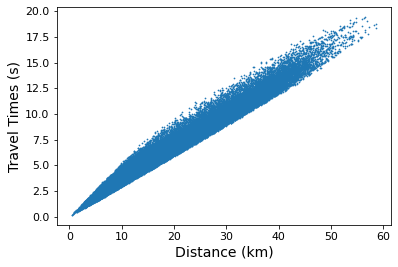

In [8]:
# Data: [rz[j], ry[j], rx[j], sz[i], sy[i], sx[i], pz0[i, j], py0[i, j], px0[i, j], T0[i, j], tau0[i, j], 3.2, T_data[i, j]]
dist = ((data[:, 0] - data[:, 3])**2 + (data[:, 1] - data[:, 4])**2 + (data[:, 2] - data[:, 5])**2)**0.5
plt.scatter(dist, data[:, -1], s=0.5)
plt.xlabel('Distance (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Travel Times (s)', fontsize=14)
plt.yticks(fontsize=11)
# plt.ylim((0, 8))
plt.savefig('./t_dist.png', dpi=600)
plt.show()

In [9]:
# points for prediction

T0_all_pred = np.zeros((nz_pred, ny_pred, nx_pred, nr))
px0_all_pred = np.zeros((nz_pred, ny_pred, nx_pred, nr))
py0_all_pred = np.zeros((nz_pred, ny_pred, nx_pred, nr))
pz0_all_pred = np.zeros((nz_pred, ny_pred, nx_pred, nr))
ekl_data_pred = np.zeros((nz_pred, ny_pred, nx_pred, nr, 11))
for h in range(nz_pred):
    for i in range(ny_pred):
        for j in range(nx_pred):
            for k in range(nr):
                if v_init != 0:
                    T0_all_pred[h, i, j, k] = np.sqrt((rz[k]-z_pred[h])**2 + (ry[k]-y_pred[i])**2 + (rx[k]-x_pred[j])**2)/v_init
                    if T0_all_pred[h, i, j, k] != 0:
                        px0_all_pred[h, i, j, k] = (x_pred[j] - rx[k])/T0_all_pred[h, i, j, k]/v_init**2
                        py0_all_pred[h, i, j, k] = (y_pred[i] - ry[k])/T0_all_pred[h, i, j, k]/v_init**2
                        pz0_all_pred[h, i, j, k] = (z_pred[h] - rz[k])/T0_all_pred[h, i, j, k]/v_init**2
                ekl_data_pred[h, i, j, k] = np.array([z_pred[h], y_pred[i], x_pred[j], rz[k], ry[k], rx[k], pz0_all_pred[h, i, j, k], 
                                                      py0_all_pred[h, i, j, k], px0_all_pred[h, i, j, k], T0_all_pred[h, i, j, k], v_init])
# ekl_data shape: (101, 101, 11, 8): (nz, nx, ns, features)
# np.set_printoptions(suppress=True, threshold=1000)
# ekl_data = ekl_data.reshape(-1, 7)
print(ekl_data_pred.shape)
T0_all_pred = T0_all_pred.reshape(-1, 1)
px0_all_pred = px0_all_pred.reshape(-1, 1)
py0_all_pred = py0_all_pred.reshape(-1, 1)
pz0_all_pred = pz0_all_pred.reshape(-1, 1)
ekl_data_pred = ekl_data_pred.reshape(-1, 11, 1)
ekl_data_pred = ekl_data_pred[:, :10, 0]
print(ekl_data_pred.shape, T0_all_pred.shape)

(5, 10, 11, 53, 11)
(29150, 10) (29150, 1)


In [10]:
# create constrant on each grid using eikonal equation (ekl)
# points of PDE residual 

from pyDOE import lhs 

def random_pde_points(n_points, nr):
    T0_all = np.zeros((n_points, nr))
    px0_all = np.zeros((n_points, nr))
    py0_all = np.zeros((n_points, nr))
    pz0_all = np.zeros((n_points, nr))
    ekl_data = []
    for k in range(nr):
        random_p = lhs(3, n_points)
        x = random_p[:, 0]*(xmax-xmin) + xmin
        y = random_p[:, 1]*(ymax-ymin) + ymin
        z = random_p[:, 2]*(zmax-zmin) + zmin
        T0_all[:, k] = np.sqrt((rz[k]-z)**2 + (ry[k]-y)**2 + (rx[k]-x)**2)/v_init
        index = np.where(T0_all[:, k] != 0)
        px0_all[index, k] = (x - rx[k])/T0_all[index, k]/v_init**2
        py0_all[index, k] = (y - ry[k])/T0_all[index, k]/v_init**2
        pz0_all[index, k] = (z - rz[k])/T0_all[index, k]/v_init**2
        ekl_data.append(np.array([z, y, x, rz[k]*np.ones(n_points), ry[k]*np.ones(n_points), rx[k]*np.ones(n_points), 
                                  pz0_all[:, k], py0_all[:, k], px0_all[:, k], T0_all[:, k], v_init*np.ones(n_points)]))
    ekl_data = np.array(ekl_data)
    ekl_data = ekl_data.transpose((2, 0, 1))
    print(ekl_data.shape)
    return T0_all, px0_all, py0_all, pz0_all, ekl_data 

n_points = 100000
T0_all, px0_all, py0_all, pz0_all, ekl_data = random_pde_points(n_points, nr)
# print(T0_all.shape, px0_all.shape, pz0_all.shape, ekl_data.shape)            # (10000, 20, 11)

(100000, 53, 11)


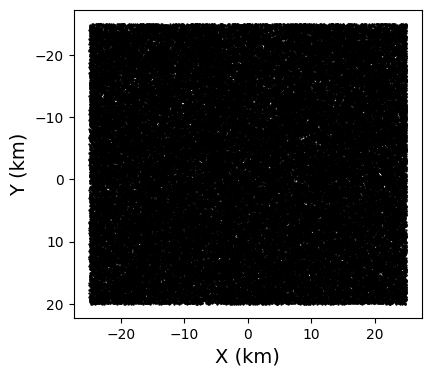

In [11]:
# Plot the velocity model with the source location

plt.style.use('default')

plt.figure(figsize=(4.5,4))

ax = plt.gca()
ax.scatter(ekl_data[:,0,2], ekl_data[:,0,1], marker='.', c='k', s=2)

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=10)

plt.gca().invert_yaxis()

ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.yaxis.set_major_locator(plt.MultipleLocator(10))

In [12]:
import math
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch import Tensor
from torch.nn import MSELoss
from torch.optim import SGD, Adam, RMSprop
from torch.autograd import Variable, grad
from torch.cuda.amp import autocast
from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler

def init_weights(m):
    if type(m) == torch.nn.Linear:
        stdv = (1. / math.sqrt(m.weight.size(1))/1.)*2        # m.weight.size(1) = 20 if nl = 10
        m.weight.data.uniform_(-stdv,stdv)
        m.bias.data.uniform_(-stdv,stdv)

def init_weights2(m):             # glorot_uniform 
    if type(m) == torch.nn.Linear: 
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.constant_(m.bias, 0)

/home/yang/Softwares/Anaconda3/envs/sciann/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(1234)

In [14]:
class NN_t(torch.nn.Module):
    def __init__(self, nl=10, activation=torch.nn.LeakyReLU()):
    # def __init__(self, nl=10, activation=torch.nn.ELU()):
            super(NN_t, self).__init__()
            self.act = activation
            self.sigmoid = torch.nn.Sigmoid()

            # Input Structure
            self.fc_t0  = Linear(6, 100)

            # Resnet Block
            self.fc_list_t = torch.nn.ModuleList([Linear(100, 100) for i in range(nl)])

            # Output structure
            self.fc_t1  = Linear(100, 1)

    def forward(self, xt):
        xt = self.act(self.fc_t0(xt))
        for i in range(len(self.fc_list_t)):
            xt = self.act(self.fc_list_t[i](xt))

        # tau = 5*self.sigmoid(self.fc_t1(xt))
        tau = self.act(self.fc_t1(xt))
        return tau

class NN_v(torch.nn.Module):
    def __init__(self, nl=10, activation=torch.nn.LeakyReLU()):
        super(NN_v, self).__init__()
        self.act = activation
        self.sigmoid = torch.nn.Sigmoid()

        # Input Structure
        self.fc_v0  = Linear(3, 50)

        # Resnet Block
        self.fc_list_v = torch.nn.ModuleList([Linear(50, 50) for i in range(nl)])

        # Output structure
        self.fc_v1  = Linear(50, 1)

    def forward(self, xv):
        xv = self.act(self.fc_v0(xv))
        for i in range(len(self.fc_list_v)):
            xv = self.act(self.fc_list_v[i](xv))

        v = 10*self.sigmoid(self.fc_v1(xv))
        # v = 5*self.act(self.fc_v1(xv))
        return v

# Data: [rz[j], ry[j], rx[j], sz[i], sy[i], sx[i], pz0[i, j], py0[i, j], px0[i, j], T0[i, j], tau0[i, j], 3.2, T_data[i, j]]
# pair_loc: [rz, rx, sz, sx]
# factors: [pz0, px0, T0]
# st_loc: [rz, rx]


def PDELoss(pair_loc, factors, tau_pred, v_pred, device):
    dtau  = torch.autograd.grad(outputs=tau_pred, inputs=pair_loc, grad_outputs=torch.ones(tau_pred.size()).to(device), 
                        only_inputs=True, create_graph=True, retain_graph=True)[0]
    pz0 = torch.unsqueeze(factors[:, 0], dim=1)
    py0 = torch.unsqueeze(factors[:, 1], dim=1)
    px0 = torch.unsqueeze(factors[:, 2], dim=1)
    T0 = torch.unsqueeze(factors[:, 3], dim=1)
    dtau_drz = torch.unsqueeze(dtau[:, 0], dim=1)
    dtau_dry = torch.unsqueeze(dtau[:, 1], dim=1)
    dtau_drx = torch.unsqueeze(dtau[:, 2], dim=1)

    s_eikonal = dtau_drz**2 + dtau_dry**2 + dtau_drx**2
    s_pred = 1.0/v_pred**2
    pde_loss = F.mse_loss(s_eikonal, s_pred)
    loss = pde_loss
    return loss

###  with PDE loss ###
def DataLoss(pair_loc, factors, tau_pred, tau_obs, v_pred, device):
    dtau  = torch.autograd.grad(outputs=tau_pred, inputs=pair_loc, grad_outputs=torch.ones(tau_pred.size()).to(device), 
                        only_inputs=True, create_graph=True, retain_graph=True)[0]
    pz0 = torch.unsqueeze(factors[:, 0], dim=1)
    py0 = torch.unsqueeze(factors[:, 1], dim=1)
    px0 = torch.unsqueeze(factors[:, 2], dim=1)
    T0 = torch.unsqueeze(factors[:, 3], dim=1)
    dtau_drz = torch.unsqueeze(dtau[:, 0], dim=1)
    dtau_dry = torch.unsqueeze(dtau[:, 1], dim=1)
    dtau_drx = torch.unsqueeze(dtau[:, 2], dim=1)

    s_eikonal = dtau_drz**2 + dtau_dry**2 + dtau_drx**2
    s_pred = 1.0/v_pred**2
    pde_loss = F.mse_loss(s_eikonal, s_pred)
    t_loss = F.mse_loss(tau_pred, tau_obs)
    loss = torch.mean(pde_loss + t_loss)
    return loss, pde_loss, t_loss

###  without PDE loss ###
def DataLoss2(tau_pred, tau_obs, device):       
    t_loss = F.mse_loss(tau_pred, tau_obs)
    # loss_t = (torch.sum((tau_pred - tau_obs)**2)/len(tau_obs))**0.5
    loss = t_loss
    return loss



In [15]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, vjp, jvp, jacrev

def calcate_ntk(net, x1, x2, compute='trace'):
    fnet, params = make_functional(net)

    def fnet_single(params, x):
        return fnet(params, x.unsqueeze(0)).squeeze(0)

    # Compute J(x1)
    jac1 = vmap(jacrev(fnet_single), (None, 0))(params, x1)
    jac1 = [j.flatten(2) for j in jac1]

    # Compute J(x2)
    jac2 = vmap(jacrev(fnet_single), (None, 0))(params, x2)
    jac2 = [j.flatten(2) for j in jac2]
    
    # Compute J(x1) @ J(x2).T
    einsum_expr = None
    if compute == 'full':
        einsum_expr = 'Naf,Mbf->NMab'
    elif compute == 'trace':
        einsum_expr = 'Naf,Maf->NM'
    elif compute == 'diagonal':
        einsum_expr = 'Naf,Maf->NMa'
    else:
        assert False

    result = torch.stack([torch.einsum(einsum_expr, j1, j2) for j1, j2 in zip(jac1, jac2)])
    result = result.sum(0)
    return result


def calcate_pde_ntk(net, x1, x2, factors, compute='trace'):
    pz0 = torch.unsqueeze(factors[:, 0], dim=1)
    px0 = torch.unsqueeze(factors[:, 1], dim=1)
    T0 = torch.unsqueeze(factors[:, 2], dim=1)

    fnet, params = make_functional(net)

    def fnet_x(params, x):
        # X = torch.cat((x, z, t), dim=1)
        u = fnet(params, x)

        return u

    def calc_vjp_x(params, x):
        (vjp0, vjpfunc) = vjp(fnet_x, params, x)

        index = torch.ones((len(x), 1)).to(device)
        (_, vjp_x) = vjpfunc(index)
        # print(vjp_x.shape)

        return vjp_x

    def calc_vjp_res(params, x):
        tau_pred = fnet_x(params, x)
        vjp_x = calc_vjp_x(params, x)
        dtau_drz = torch.unsqueeze(vjp_x[:, 0], dim=1)
        dtau_drx = torch.unsqueeze(vjp_x[:, 1], dim=1)

        res = (T0*dtau_drz + tau_pred*pz0)**2 + (T0*dtau_drx + tau_pred*px0)**2
        # res = vjp_x - 1000

        return res

    jac1 = jacrev(calc_vjp_res)(params, x1)
    jac1_flat = [j.flatten(2) for j in jac1]

    jac2 = jacrev(calc_vjp_res)(params, x2)
    jac2_flat = [j.flatten(2) for j in jac2]
    # jac2_flat = jac1_flat

    # Compute J(x1) @ J(x2).T
    einsum_expr = None
    if compute == 'full':
        einsum_expr = 'Naf,Mbf->NMab'
    elif compute == 'trace':
        einsum_expr = 'Naf,Maf->NM'
    elif compute == 'diagonal':
        einsum_expr = 'Naf,Maf->NMa'
    else:
        assert False

    result = torch.stack([torch.einsum(einsum_expr, j1, j2) for j1, j2 in zip(jac1_flat, jac2_flat)])
    result = result.sum(0).reshape(len(x1), len(x2))

    return result

In [16]:
T0_all = T0_all.reshape(-1, 1)
ekl_data = ekl_data.reshape(-1, 11, 1)
ekl_data = ekl_data[:, :10, 0]
print(ekl_data.shape, T0_all.shape)

# data = data.reshape(13, -1)
# data = data.transpose((1, 0))
print(data.shape)

(5300000, 10) (5300000, 1)
(53000, 13)


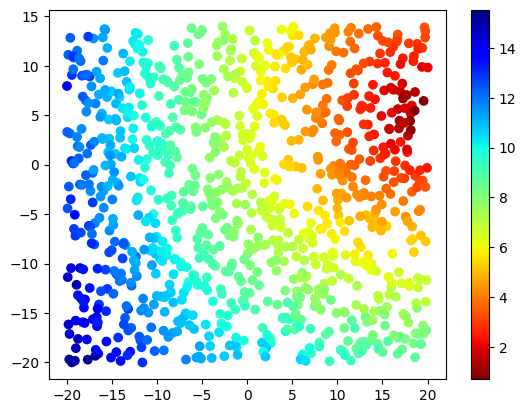

In [17]:
# print(np.where(data[:, 2]==0))
np.set_printoptions(threshold=np.inf)
part = data[np.where((data[:, 3]==rz[20])&(data[:, 4]==ry[20])&(data[:, 5]==rx[20]))]
# print(part)
data_array = np.concatenate((part[:, :3], part[:, 9:13]), axis=1)
# [rz[j], ry[j], rx[j], T0[i, j], tau0[i, j], 3.2, T_data[i, j]])
# print(data_array)


colormap = plt.cm.get_cmap('jet_r') # 使用'viridis'颜色映射

# 绘制散点图
plt.scatter(data_array[:, 2], data_array[:, 1], c=data_array[:, 6], cmap=colormap)

# 添加颜色条
plt.colorbar()

# 显示图形
plt.show()

In [18]:
nn_t = NN_t()
nn_t.apply(init_weights2)
nn_t.float()
nn_t.to(torch.device(device=device))

nn_v = NN_v()
nn_v.apply(init_weights2)
nn_v.float()
nn_v.to(torch.device(device=device))

pred_grid = torch.from_numpy(pred_grid.astype(np.float32)).cuda()
v_ini = nn_v.forward(pred_grid)

# Data: [rz[j], ry[j], rx[j], sz[i], sy[i], sx[i], pz0[i, j], py0[i, j], px0[i, j], T0[i, j], tau0[i, j], 3.2, T_data[i, j]]
tmp = torch.from_numpy(np.linspace(0, 1, len(ekl_data)))
tmp = torch.unsqueeze(tmp, dim=1)
ekl_data_tensor = torch.from_numpy(ekl_data.astype(np.float32))
ekl_dataset = torch.utils.data.TensorDataset(ekl_data_tensor, tmp)

tmp2 = torch.from_numpy(np.linspace(0, 1, len(data)))
tmp2 = torch.unsqueeze(tmp2, dim=1)
data_tensor = torch.from_numpy(data.astype(np.float32))
obs_dataset = torch.utils.data.TensorDataset(data_tensor, tmp2)
print(f'PDE points: {len(ekl_data_tensor)}, Data points: {len(data_tensor)}')


########### Train #############
from itertools import chain 
# optimizer = torch.optim.Adam(chain(nn_t.parameters(), nn_v.parameters()), lr=0.001)
optimizer = torch.optim.Adam([{'params': nn_t.parameters(), 'lr': 0.0005},
                              {'params': nn_v.parameters(), 'lr': 0.0005}])
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
epoch_num = 200
ekl_batch_size = 1024
# ekl_batch_size = len(ekl_dataset)
obs_batch_size = 256
ntk_freq = 10
# obs_batch_size = len(obs_dataset)
loss_all = []
pde_loss_all = []
data_loss_all = []
ntk_all = {'sum':[], 'pde':[], 'data':[]}
for epoch in range(epoch_num):
    ekl_data_loader = torch.utils.data.DataLoader(dataset=ekl_dataset, batch_size=ekl_batch_size, shuffle=True)
    obs_data_loader = torch.utils.data.DataLoader(dataset=obs_dataset, batch_size=obs_batch_size, shuffle=True)
    obs_data_iter = iter(obs_data_loader)
    for i, ekl_data_batch in enumerate(ekl_data_loader):
        ekl_data_batch = ekl_data_batch[0]
        ekl_pair_loc_batch = ekl_data_batch[:, :6].cuda()
        ekl_factors_batch = ekl_data_batch[:, 6:10].cuda()

        ekl_pair_loc_batch.requires_grad_()
        ekl_tau_pred = nn_t.forward(ekl_pair_loc_batch)

        st_loc_batch = ekl_data_batch[:, :3].cuda()
        ekl_v_pred = nn_v.forward(st_loc_batch)
        pde_loss = PDELoss(ekl_pair_loc_batch, ekl_factors_batch, ekl_tau_pred, ekl_v_pred, device)
        try:
            obs_data_batch = next(obs_data_iter)
        except StopIteration:
            obs_data_loader = torch.utils.data.DataLoader(dataset=obs_dataset, batch_size=obs_batch_size, shuffle=True)
            obs_data_iter = iter(obs_data_loader)
            obs_data_batch = next(obs_data_iter)

        obs_data_batch = obs_data_batch[0].cuda()
        obs_pair_loc_batch = obs_data_batch[:, :6]

        # obs_pair_loc_batch.requires_grad_()
        obs_tau_batch = obs_data_batch[:, 12].unsqueeze(dim=1)

        pred_tau = nn_t.forward(obs_pair_loc_batch)
        data_loss = DataLoss2(pred_tau, obs_tau_batch, device=device)

        # ntk weight
        if i == 'None' and epoch%ntk_freq==0:
            ntk_obs = calcate_ntk(nn_t, obs_pair_loc_batch, obs_pair_loc_batch)
            tr_ntk_obs = torch.trace(ntk_obs)
            tr_ntk_obs = tr_ntk_obs.cpu().detach().numpy()

            ntk_pde = calcate_pde_ntk(nn_t, ekl_pair_loc_batch, ekl_pair_loc_batch, ekl_factors_batch)
            tr_ntk_pde = torch.trace(ntk_pde)
            tr_ntk_pde = tr_ntk_pde.cpu().detach().numpy()

            # # Compute eigenvalues
            # lambda_K, eigvec_K = np.linalg.eig(ntk_obs.detach().cpu().numpy())
            # # Sort in descresing order
            # lambda_K = np.sort(np.real(lambda_K))[::-1]
            # print('Max eigenvalue', lambda_K[0])

            # # Visualize the eigenvalues of the NTK
            # fig = plt.figure(figsize=(6, 5))
            # ax = plt.axes()
            # ax.plot(lambda_K)
            # plt.xscale('log')
            # plt.yscale('log')
            # ax.set_xlabel('index')
            # ax.set_ylabel(r'$\lambda$')
            # plt.show()

            tr_ntk_sum = tr_ntk_obs + tr_ntk_pde

            ntk_all['sum'].append(tr_ntk_sum)
            ntk_all['data'].append(tr_ntk_obs)
            ntk_all['pde'].append(tr_ntk_pde)

            del ntk_obs, ntk_pde

        # weighted_loss = tr_ntk_sum/tr_ntk_obs*data_loss + tr_ntk_sum/tr_ntk_pde*pde_loss
        weighted_loss = data_loss + pde_loss
        true_loss = data_loss.cpu().detach().numpy() + pde_loss.cpu().detach().numpy()

        optimizer.zero_grad()
        weighted_loss.backward()
        optimizer.step()
        
        # del 

    lr_scheduler.step()
    print(f'Epoch {epoch+1}, loss = {true_loss:.4e}; PDE loss = {pde_loss.item():.4e}; data loss = {data_loss.item():.4e};', 
          'lr1 = {}; lr2 = {};'.format(optimizer.param_groups[0]['lr'], optimizer.param_groups[1]['lr'])) 
          # f'data weight = {tr_ntk_sum/tr_ntk_obs:.2f}; pde weight = {tr_ntk_sum/tr_ntk_pde:.2f}')

    loss_all.append(true_loss.item())
    pde_loss_all.append(pde_loss.item())
    data_loss_all.append(data_loss.item())

    if (epoch+1)%10 == 0:
        torch.save(nn_v, f'./{model_path}/{epoch+1}_v.pt')
        torch.save(nn_t, f'./{model_path}/{epoch+1}_t.pt')
        
    # break


PDE points: 5300000, Data points: 53000
Epoch 1, loss = 1.4949e-02; PDE loss = 7.4615e-04; data loss = 1.4203e-02; lr1 = 0.0005; lr2 = 0.0005;
Epoch 2, loss = 8.6653e-03; PDE loss = 5.1213e-04; data loss = 8.1531e-03; lr1 = 0.0005; lr2 = 0.0005;
Epoch 3, loss = 3.6285e-03; PDE loss = 4.1694e-04; data loss = 3.2116e-03; lr1 = 0.0005; lr2 = 0.0005;
Epoch 4, loss = 3.2461e-03; PDE loss = 3.3951e-04; data loss = 2.9066e-03; lr1 = 0.0005; lr2 = 0.0005;
Epoch 5, loss = 2.7801e-03; PDE loss = 3.1483e-04; data loss = 2.4653e-03; lr1 = 0.0005; lr2 = 0.0005;
Epoch 6, loss = 2.9438e-03; PDE loss = 3.0778e-04; data loss = 2.6360e-03; lr1 = 0.0005; lr2 = 0.0005;
Epoch 7, loss = 3.0180e-03; PDE loss = 2.6527e-04; data loss = 2.7527e-03; lr1 = 0.0005; lr2 = 0.0005;
Epoch 8, loss = 3.2027e-03; PDE loss = 2.8436e-04; data loss = 2.9183e-03; lr1 = 0.0005; lr2 = 0.0005;
Epoch 9, loss = 8.4571e-03; PDE loss = 2.6563e-04; data loss = 8.1915e-03; lr1 = 0.0005; lr2 = 0.0005;
Epoch 10, loss = 1.4154e-03; PDE 

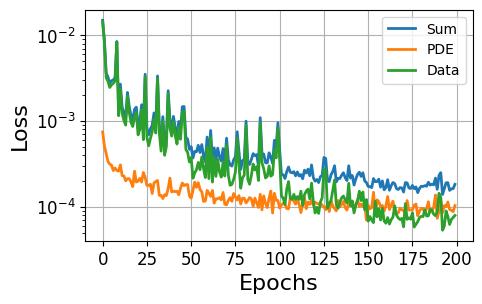

In [19]:
# Convergence history plot for verification
fig = plt.figure(figsize=(5,3))
ax = plt.axes()
ax.semilogy(list(range(epoch_num)), loss_all, linewidth=2, label='Sum')
ax.semilogy(list(range(epoch_num)), pde_loss_all, linewidth=2, label='PDE')
ax.semilogy(list(range(epoch_num)), data_loss_all, linewidth=2, label='Data')
plt.legend()

ax.set_xlabel('Epochs',fontsize=16)

plt.xticks(fontsize=12)

ax.set_ylabel('Loss',fontsize=16)
plt.yticks(fontsize=12)
plt.grid()

# # ntk history
# fig = plt.figure(figsize=(5,3))
# ax = plt.axes()
# ax.plot(list(range(0, epoch_num, ntk_freq)), ntk_all['sum'], linewidth=2, label='Sum')
# ax.plot(list(range(0, epoch_num, ntk_freq)), ntk_all['data'], linewidth=2, label='Data')
# ax.plot(list(range(0, epoch_num, ntk_freq)), ntk_all['pde'], linewidth=2, label='PDE')

# ax.set_xlabel('Epochs',fontsize=16)

# plt.xticks(fontsize=12)

# ax.set_ylabel('NTK',fontsize=16)
# plt.yticks(fontsize=12)
# plt.grid()
# plt.legend()

In [20]:
# np.savetxt(f'./{model_path}/ntk_obs', ntk_all['data'])
# np.savetxt(f'./{model_path}/ntk_pde', ntk_all['pde'])
np.savetxt(f'./{model_path}/loss_all', loss_all)
np.savetxt(f'./{model_path}/pde_loss_all', pde_loss_all)
np.savetxt(f'./{model_path}/data_loss_all', data_loss_all)

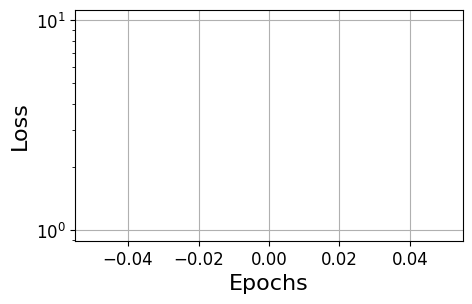

In [21]:
########### Train L-BFGS #############
optimizer = torch.optim.LBFGS(chain(nn_t.parameters(), nn_v.parameters()), lr=0.0005)
epoch_num = 0
ekl_batch_size = len(ekl_dataset)
obs_batch_size = len(obs_dataset)

ekl_data_loader = torch.utils.data.DataLoader(dataset=ekl_dataset, batch_size=ekl_batch_size, shuffle=True)
ekl_data_iter = iter(ekl_data_loader)
ekl_data_batch = next(ekl_data_iter)
ekl_data_batch = ekl_data_batch[0].cuda()

obs_data_loader = torch.utils.data.DataLoader(dataset=obs_dataset, batch_size=obs_batch_size, shuffle=True)
obs_data_iter = iter(obs_data_loader)
obs_data_batch = next(obs_data_iter)
obs_data_batch = obs_data_batch[0].cuda()

ekl_pair_loc_batch = ekl_data_batch[:, :6]
ekl_factors_batch = ekl_data_batch[:, 6:10]
ekl_pair_loc_batch.requires_grad_()

st_loc_batch = ekl_data_batch[:, :3]

obs_pair_loc_batch = obs_data_batch[:, :6]
obs_tau_batch = obs_data_batch[:, 10].unsqueeze(dim=1)

def closure():
    optimizer.zero_grad()
    ekl_tau_pred = nn_t.forward(ekl_pair_loc_batch)
    ekl_v_pred = nn_v.forward(st_loc_batch)
    pde_loss = PDELoss(ekl_pair_loc_batch, ekl_factors_batch, ekl_tau_pred, ekl_v_pred, device)
    pred_tau = nn_t.forward(obs_pair_loc_batch)
    data_loss = DataLoss2(pred_tau, obs_tau_batch, device=device)
    loss = data_loss + pde_loss
    loss.backward()
    loss_dict[epoch] = loss.cpu().item()
    pde_loss_dict[epoch] = pde_loss.cpu().item()
    data_loss_dict[epoch] = data_loss.cpu().item()
    # print(f'Epoch {epoch+1}, loss = {loss.item():.6e}; PDE loss = {pde_loss.item():.6e}; data loss = {data_loss.item():.6e}')
    return loss   

loss_dict = {}
pde_loss_dict = {}
data_loss_dict = {}
loss_all = []
pde_loss_all = []
data_loss_all = []
for epoch in range(epoch_num): 
    optimizer.step(closure=closure) 
    loss_all.append(loss_dict[epoch]) 
    pde_loss_all.append(pde_loss_dict[epoch]) 
    data_loss_all.append(data_loss_dict[epoch]) 
    # print(f'Epoch {epoch+1}, loss = {loss.item():.6e}')
    print(f'Epoch {epoch+1}, loss = {loss_dict[epoch]:.6e}; PDE loss = {pde_loss_dict[epoch]:.6e}; data loss = {data_loss_dict[epoch]:.6e}')
    
    # loss_all.append(loss.item())
    # pde_loss_all.append(pde_loss.item())
    # data_loss_all.append(data_loss.item())

# Convergence history plot for verification
fig = plt.figure(figsize=(5,3))
ax = plt.axes()
ax.semilogy(list(range(epoch_num)), loss_all, linewidth=2)

ax.set_xlabel('Epochs',fontsize=16)

plt.xticks(fontsize=12)

ax.set_ylabel('Loss',fontsize=16)
plt.yticks(fontsize=12)
plt.grid()

In [22]:
# Evaluating initial velocity model and traveltimes
# print(np.array(X_star + [velmodel,pz0,px0,T0]).shape)
# print(np.array(pred_grid).shape)
v_ini = v_ini.cpu().detach().numpy()
v_ini = v_ini.reshape(pred_Z.shape)
print(v_ini.shape)


(5, 10, 11)


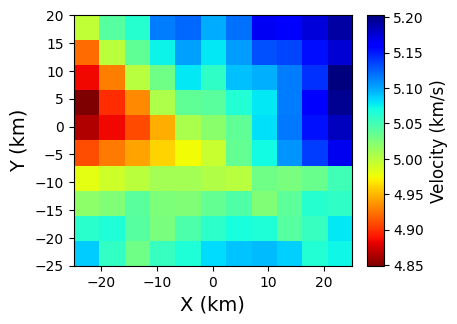

In [23]:
# Initial model 

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(v_ini[0], extent=[xmin,xmax,ymin,ymax], aspect=1, cmap="jet_r")


plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=10)

# ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
# cbar.mappable.set_clim(1.4,4.36)

cbar.set_label('Velocity (km/s)',size=12)
cbar.ax.tick_params(labelsize=10)

plt.savefig(f"./{fig_path}/vel_ini.pdf", format='pdf', bbox_inches="tight")

In [24]:
nn_v = torch.load(f'./{model_path}/200_v.pt')
nn_t = torch.load(f'./{model_path}/200_t.pt')
nn_v.to(torch.device(device='cpu')); 
nn_t.to(torch.device(device='cpu')); 

RMS=0.008126087330168778 s


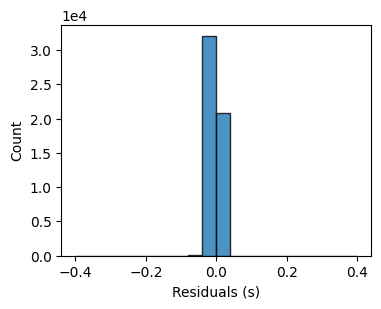

In [25]:
# calculate data residual 
pair_loc = data_tensor[:, :6]
tau_pred = nn_t.forward(pair_loc)
T_pred = tau_pred.detach().numpy()
T_label = data_tensor[:, 12:13].numpy()
diff = T_pred - T_label
diff = (diff.T)[0]
rms = np.mean(diff**2)**0.5
print(f'RMS={rms} s')

plt.figure(figsize=(4,3))
fontsize = 10
ax = plt.hist(diff, bins=20, range=(-0.4, 0.4), rwidth=1, alpha=0.8, ec='k', label='Initial')
plt.xlabel('Residuals (s)', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.ticklabel_format(style='sci', scilimits=(-1, 1), axis='y')
plt.tick_params(labelsize=fontsize)
plt.savefig(f"./{fig_path}/hist.pdf", format='pdf', bbox_inches="tight")

In [26]:
pair_loc = torch.from_numpy(ekl_data_pred[:, :6].astype(np.float32))
# T0 = torch.from_numpy(T0_all_pred.astype(np.float32))
pred_grid = pred_grid.cpu()
test_batch_size = 10000

data_size = len(pair_loc)
if data_size%test_batch_size == 0:
    batch_num = data_size//test_batch_size
else:
    batch_num = data_size//test_batch_size + 1
    
T_pred = []
v_pred3_all = []
for i in range(batch_num):
    if (i+1)*test_batch_size < data_size:
        batch_pair_loc = pair_loc[i*test_batch_size:(i+1)*test_batch_size]
        batch_T0_all_pred = T0_all_pred[i*test_batch_size:(i+1)*test_batch_size]
    else:
        batch_pair_loc = pair_loc[i*test_batch_size:]
        batch_T0_all_pred = T0_all_pred[i*test_batch_size:]

    batch_pair_loc.requires_grad_()
    batch_tau_pred = nn_t.forward(batch_pair_loc)
    batch_T_pred = batch_tau_pred.detach().numpy()
    T_pred.extend(batch_T_pred)

    dtau = torch.autograd.grad(outputs=batch_tau_pred, inputs=batch_pair_loc, grad_outputs=torch.ones(batch_tau_pred.size()), 
                               only_inputs=True, create_graph=True, retain_graph=True)[0]
    dtau_drz = torch.unsqueeze(dtau[:, 0], dim=1)
    dtau_dry = torch.unsqueeze(dtau[:, 1], dim=1)
    dtau_drx = torch.unsqueeze(dtau[:, 2], dim=1)
    T0 = batch_T0_all_pred
    batch_v_pred3 = 1/((dtau_drz.detach().numpy())**2 + (dtau_dry.detach().numpy())**2 + 
                       (dtau_drx.detach().numpy())**2)**0.5
    v_pred3_all.extend(batch_v_pred3)

T_pred = np.array(T_pred)
# T_pred = tau_pred.detach().numpy()
# print(T_pred.shape)
T_pred = T_pred.reshape((nz_pred, ny_pred, nx_pred, ns))
print(T_pred.shape)

v_pred2 = nn_v.forward(pred_grid)
v_pred2 = v_pred2.detach().numpy()
v_pred2 = v_pred2.reshape(pred_Y.shape)

v_pred3_all = np.array(v_pred3_all)
v_pred3_all = v_pred3_all.reshape((nz_pred, ny_pred, nx_pred, ns))
# v_pred3_all = v_pred3_all.numpy()

vmax = 7
vmin = 3
v_pred3 = np.zeros(v_pred3_all.shape[:3])
v_std = np.zeros(v_pred3_all.shape[:3])
for i in range(v_pred3_all.shape[0]):
    for j in range(v_pred3_all.shape[1]):
        for k in range(v_pred3_all.shape[2]):
            tmp = v_pred3_all[i, j, k, :]
            valid = tmp[np.where((tmp<=vmax)&(tmp>=vmin))]
            v_pred3[i, j, k] = np.mean(valid)
            v_std[i, j, k] = (np.mean((valid - np.mean(valid))**2)/len(valid))**0.5

print(v_pred3.shape)


ValueError: cannot reshape array of size 29150 into shape (5,10,11,1000)

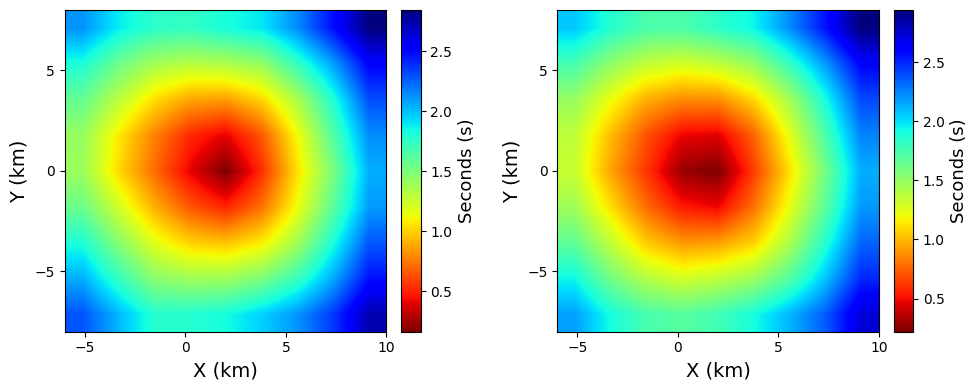

In [ ]:
# Plot the PINN solution error

plt.style.use('default')

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
# plt.imshow(T_pred[:,:,0], extent=[xmin,xmax,ymin,ymax], aspect=1, cmap="jet_r")
im = plt.imshow(T_pred[5,:,:,0], extent=[xmin,xmax,ymax,ymin], aspect=1, interpolation='bilinear', cmap="jet_r")

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=10)

plt.gca().invert_yaxis()

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5))

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Seconds (s)',size=13)
cbar.ax.tick_params(labelsize=10)

plt.subplot(1,2,2)
# plt.imshow(T_data_all[:,:,0], extent=[xmin,xmax,ymin,ymax], aspect=1, cmap="jet_r")
im = plt.imshow(T_pred[5,:,:,1], extent=[xmin,xmax,ymax,ymin], aspect=1, interpolation='bilinear', cmap="jet_r")

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=10)

plt.gca().invert_yaxis()

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5))

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Seconds (s)',size=13)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()


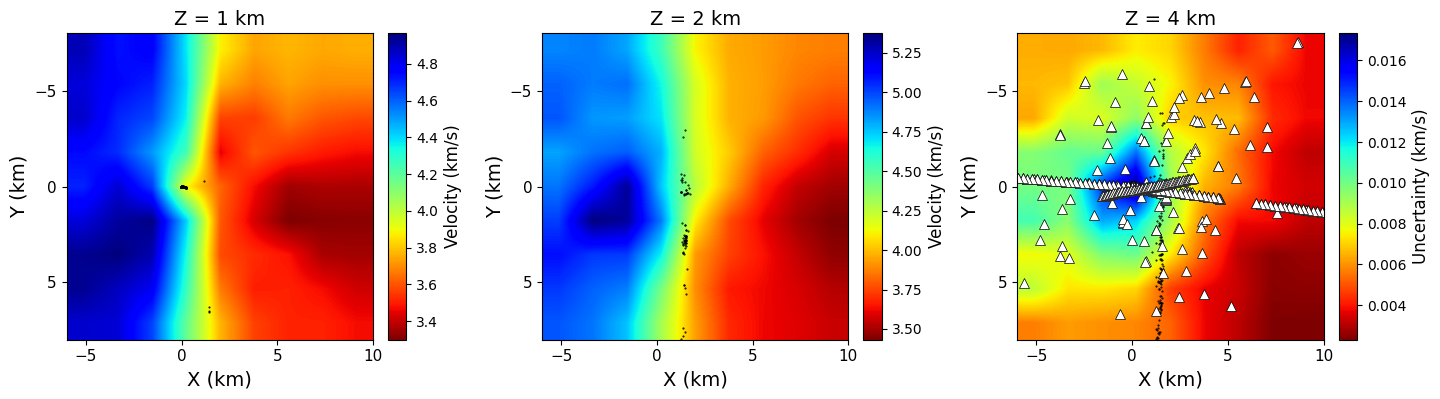

In [ ]:
# print('Z:', z_pred)
# print('Y:', y_pred)
# print('X:', x_pred)
# Plot the PINN solution error

plt.style.use('default')

plt.figure(figsize=(14.5,4))

ax = plt.subplot(1,3,1)
im = ax.imshow(v_pred2[np.where(abs(z_pred-1.0)<0.01)[0][0]], extent=[xmin,xmax,ymax,ymin], aspect=1, interpolation='bilinear', cmap="jet_r")
# im = ax.pcolor(x_pred, y_pred, v_pred3, shading='auto', cmap="jet_r")
# ax.scatter(sx, sy, marker='*', color='violet', s=60)
ax.scatter(sx[np.where((sz>=0.75)&(sz<=1.25))], sy[np.where((sz>=0.75)&(sz<=1.25))], marker='.', color='k', s=1)
# ax.plot(rx, ry, 'k^', markersize=7, markerfacecolor='w', markeredgewidth='0.5')

# im.set_clip_path(path, im.get_transform())

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=11)

plt.title('Z = 1 km', fontsize=14)

plt.xlim((-6, 10))
plt.ylim((-8, 8))

plt.gca().invert_yaxis()

ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_locator(plt.MultipleLocator(5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
# cbar.mappable.set_clim(3.6, 5.35)
# cbar.mappable.set_clim(2.88, 3.52)

cbar.set_label('Velocity (km/s)',size=12)
cbar.ax.tick_params(labelsize=10)


ax = plt.subplot(1,3,2)
im = ax.imshow(v_pred2[np.where(abs(z_pred-2.0)<0.01)[0][0]], extent=[xmin,xmax,ymax,ymin], aspect=1, interpolation='bilinear', cmap="jet_r")
# im = ax.pcolor(x_pred, y_pred, v_pred3, shading='auto', cmap="jet_r")
# ax.scatter(sx, sy, marker='*', color='violet', s=60)
ax.scatter(sx[np.where((sz>=1.75)&(sz<=2.5))], sy[np.where((sz>=1.75)&(sz<=2.5))], marker='.', color='k', s=1)
# ax.plot(rx, ry, 'k^', markersize=7, markerfacecolor='w', markeredgewidth='0.5')

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=11)

plt.title('Z = 2 km', fontsize=14)

plt.xlim((-6, 10))
plt.ylim((-8, 8))

plt.gca().invert_yaxis()

ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_locator(plt.MultipleLocator(5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
# cbar.mappable.set_clim(2.88, 3.52)

cbar.set_label('Velocity (km/s)',size=12)
cbar.ax.tick_params(labelsize=10)


ax = plt.subplot(1,3,3)
im = ax.imshow(v_std[np.where(abs(z_pred-2.0)<0.01)[0][0]], extent=[xmin,xmax,ymax,ymin], aspect=1, interpolation='bilinear', cmap="jet_r")
# im = ax.pcolor(x_pred, y_pred, v_pred3, shading='auto', cmap="jet_r")
# ax.scatter(sx, sy, marker='*', color='violet', s=60)
ax.scatter(sx[np.where((sz>=2.5)&(sz<=3.5))], sy[np.where((sz>=2.5)&(sz<=3.5))], marker='.', color='k', s=1)
ax.plot(rx, ry, 'k^', markersize=7, markerfacecolor='w', markeredgewidth='0.5')

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=11)

plt.xlim((-6, 10))
plt.ylim((-8, 8))

plt.title('Z = 4 km', fontsize=14)

plt.gca().invert_yaxis()

ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_locator(plt.MultipleLocator(5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
# cbar.mappable.set_clim(2.89, 3.52)

cbar.set_label('Uncertainty (km/s)',size=12)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()

plt.savefig(f"./{fig_path}/vel_inv.pdf", format='pdf', bbox_inches="tight")

IndexError: index 0 is out of bounds for axis 0 with size 0

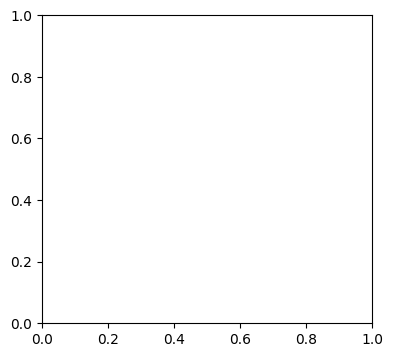

In [ ]:
# print('Z:', z_pred)
# print('Y:', y_pred)
# print('X:', x_pred)
# print(v_pred2.shape)
# Plot the PINN solution error

plt.style.use('default')

plt.figure(figsize=(14.5,4))

ax = plt.subplot(1,3,1)
im = ax.imshow(v_pred2[:, np.where(abs(y_pred+1.0)<0.01)[0][0], :], extent=[xmin,xmax,zmax,zmin], aspect=1, interpolation='bilinear', cmap="jet_r")
# im = ax.pcolor(x_pred, y_pred, vel, shading='auto', cmap="jet_r")
# ax.scatter(sx[np.where((sy>=-3)&(sy<=-1.5))], sz[np.where((sy>=-3)&(sy<=-1.5))], marker='.', color='k', s=1)

# im.set_clip_path(path, im.get_transform())

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Z (km)', fontsize=14)
plt.yticks(fontsize=11)

plt.xlim((-6, 10))
plt.ylim((5, -0.5))

plt.title('Y = -2 km', fontsize=14)

# plt.gca().invert_yaxis()

ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_locator(plt.MultipleLocator(5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
# cbar.mappable.set_clim(np.min(v_pred2[:, np.where(abs(y_pred+1)<0.01)[0][0], :]), 5.0)

cbar.set_label('Vp (km/s)',size=12)
cbar.ax.tick_params(labelsize=10)

ax = plt.subplot(1,3,2)
im = ax.imshow(v_pred3[:, np.where(abs(y_pred+1)<0.01)[0][0], :], extent=[xmin,xmax,zmax,zmin], aspect=1, interpolation='bilinear', cmap="jet_r")
# im = ax.pcolor(x_pred, y_pred, v_pred3, shading='auto', cmap="jet_r")
# ax.scatter(sx[np.where((sy>=-0.5)&(sy<=0.5))], sz[np.where((sy>=-0.5)&(sy<=0.5))], marker='.', color='k', s=1)

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Z (km)', fontsize=14)
plt.yticks(fontsize=11)

plt.xlim((-6, 10))
plt.ylim((5, -0.5))

plt.title('Y = 0 km', fontsize=14)

# plt.gca().invert_yaxis()

ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_locator(plt.MultipleLocator(5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
# cbar.mappable.set_clim(np.min(v_pred2[:, np.where(abs(y_pred+1)<0.01)[0][0], :]), 5.0)

cbar.set_label('Vp (km/s)',size=12)
cbar.ax.tick_params(labelsize=10)


ax = plt.subplot(1,3,3)
im = ax.imshow(v_std[:, np.where(abs(y_pred+1)<0.01)[0][0], :], extent=[xmin,xmax,zmax,zmin], aspect=1, interpolation='bilinear', cmap="jet_r")
# ax.contour(x_pred, z_pred, v_pred2[:, np.where(abs(y_pred-1)<0.01)[0][0], :], levels=[3.8, 4.5, 5.15], colors='white')
# im = ax.pcolor(x_pred, y_pred, v_pred3, shading='auto', cmap="jet_r")
# ax.scatter(sx[np.where((sy>=1.5)&(sy<=3))], sz[np.where((sy>=1.5)&(sy<=3))], marker='.', color='k', s=1)

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Z (km)', fontsize=14)
plt.yticks(fontsize=11)

plt.xlim((-6, 10))
plt.ylim((5, -0.5))

plt.title('Y = 2 km', fontsize=14)
# plt.gca().invert_yaxis()

ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_locator(plt.MultipleLocator(5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
# cbar.mappable.set_clim(np.min(v_pred2[:, np.where(abs(y_pred+1)<0.01)[0][0], :]), 4.9)
# cbar.mappable.set_clim(2.89, 3.52)

cbar.set_label('Vp (km/s)',size=12)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()

plt.savefig(f"./{fig_path}/vel_inv2.pdf", format='pdf', bbox_inches="tight")

NameError: name 'vel' is not defined

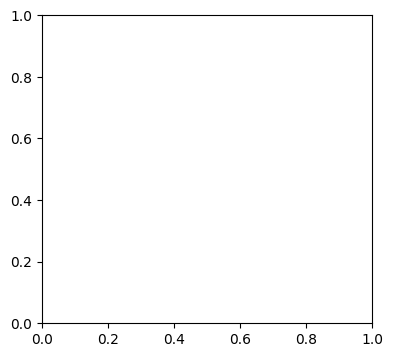

In [ ]:
# Plot the PINN solution error

plt.style.use('default')

plt.figure(figsize=(14.5,4))

ax = plt.subplot(1,3,1)
im = ax.imshow(vel[:, :, 5], extent=[ymin,ymax,zmin,zmax], aspect=1, interpolation='bilinear', cmap="jet_r")
# im = ax.pcolor(x_pred, y_pred, vel, shading='auto', cmap="jet_r")
ax.plot(sy, sz, 'k^', markersize=7, markerfacecolor='w', markeredgewidth='0.5')
# ax.scatter(sx, sy, marker='*', color='violet', s=60)

# im.set_clip_path(path, im.get_transform())

plt.xlabel('Y (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Z (km)', fontsize=14)
plt.yticks(fontsize=11)

plt.gca().invert_yaxis()

ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
cbar.mappable.set_clim(2.89, 3.52)

cbar.set_label('Velocity (km/s)',size=12)
cbar.ax.tick_params(labelsize=10)

ax = plt.subplot(1,3,2)
im = ax.imshow(v_pred2[:, :, 5], extent=[ymin,ymax,zmin,zmax], aspect=1, interpolation='bilinear', cmap="jet_r")
# im = ax.pcolor(x_pred, y_pred, v_pred3, shading='auto', cmap="jet_r")
# ax.scatter(sx, sy, marker='*', color='violet', s=60)
ax.plot(sy, sz, 'k^', markersize=7, markerfacecolor='w', markeredgewidth='0.5')

# im.set_clip_path(path, im.get_transform())

rect_y = np.arange(ymin + 0.1, ymax, 0.2)
rect_z = np.arange(zmin + 0.1, zmax, 0.2)
rect_Z, rect_Y = np.meshgrid(rect_z, rect_y, indexing='ij') 
rect_Z = rect_Z.reshape(-1)
rect_Y = rect_Y.reshape(-1)
ax.plot(rect_Y, rect_Z, 'ws', markersize=18, markerfacecolor='none', markeredgewidth='2')

plt.xlabel('Y (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Z (km)', fontsize=14)
plt.yticks(fontsize=11)

plt.gca().invert_yaxis()

ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
cbar.mappable.set_clim(2.89, 3.52)

cbar.set_label('Velocity (km/s)',size=12)
cbar.ax.tick_params(labelsize=10)


ax = plt.subplot(1,3,3)
im = ax.imshow(v_std[:, :, 5], extent=[ymin,ymax,zmin,zmax], aspect=1, interpolation='bilinear', cmap="jet_r")
# im = ax.pcolor(x_pred, y_pred, v_pred3, shading='auto', cmap="jet_r")
# ax.scatter(sx, sy, marker='*', color='violet', s=60)
ax.plot(sy, sz, 'k^', markersize=7, markerfacecolor='w', markeredgewidth='0.5')

# im.set_clip_path(path, im.get_transform())

rect_y = np.arange(ymin + 0.1, ymax, 0.2)
rect_z = np.arange(zmin + 0.1, zmax, 0.2)
rect_Z, rect_Y = np.meshgrid(rect_z, rect_y, indexing='ij') 
rect_Z = rect_Z.reshape(-1)
rect_Y = rect_Y.reshape(-1)
ax.plot(rect_Y, rect_Z, 'ws', markersize=18, markerfacecolor='none', markeredgewidth='2')

plt.xlabel('Y (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Z (km)', fontsize=14)
plt.yticks(fontsize=11)

plt.gca().invert_yaxis()

ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
# cbar.mappable.set_clim(2.89, 3.52)

cbar.set_label('Uncertainty (km/s)',size=12)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()

plt.savefig(f"./{fig_path}/vel_inv3.pdf", format='pdf', bbox_inches="tight")

MSE = 0.04126187585200624


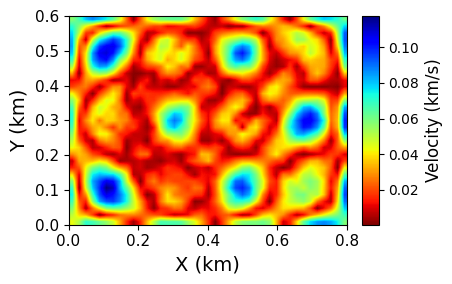

In [ ]:
# Plot the PINN solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

diff = v_pred2[5]-vel[5]
mse = np.mean(np.square(diff))**0.5
print(f'MSE = {mse}')

ax = plt.gca()
im = ax.imshow(np.abs(diff), extent=[xmin,xmax,ymax,ymin], aspect=1, interpolation='bilinear', cmap="jet_r")

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=11)

plt.gca().invert_yaxis()

# ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('Velocity (km/s)',size=12)
cbar.ax.tick_params(labelsize=10)

plt.savefig(f"./{fig_path}/vel_error.pdf", format='pdf', bbox_inches="tight")

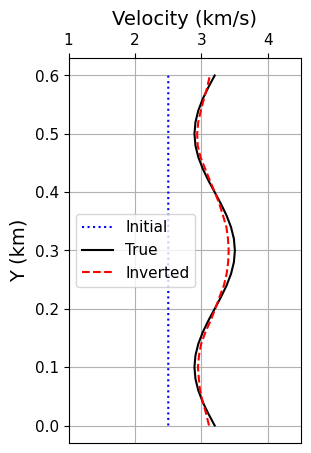

In [ ]:
plt.style.use('default')

plt.figure(figsize=(3,5))

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

ax = plt.gca()
#ax.xaxis.set_tick_params(labeltop='on')

v_true = vel

plt.plot(v_ini[5,:,36], y_pred, 'b:')
plt.plot(v_true[5,:,36], y_pred, 'k')
plt.plot(v_pred2[5,:,36], y_pred, 'r--')

ax.set_title('Velocity (km/s)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=11)

# plt.ylim([0,1])
plt.xlim([1.,4.5])

# plt.gca().invert_yaxis()

plt.legend(['Initial','True','Inverted'], fontsize=11)

plt.grid()

plt.savefig(f"./{fig_path}/vel_trace1.pdf", format='pdf', bbox_inches="tight")

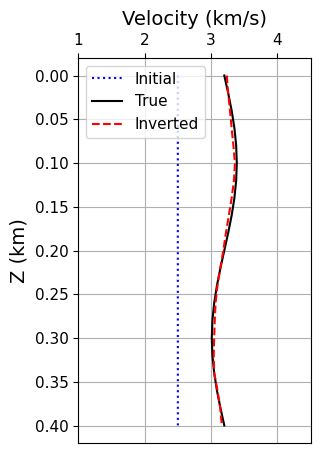

In [ ]:
plt.style.use('default')

plt.figure(figsize=(3,5))

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

ax = plt.gca()
#ax.xaxis.set_tick_params(labeltop='on')

v_true = vel

plt.plot(v_ini[:,15,12], z_pred, 'b:')
plt.plot(v_true[:,15,12], z_pred, 'k')
plt.plot(v_pred2[:,15,12], z_pred, 'r--')

ax.set_title('Velocity (km/s)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Z (km)', fontsize=14)
plt.yticks(fontsize=11)

# plt.ylim([0,1])
plt.xlim([1.,4.5])

plt.gca().invert_yaxis()

plt.legend(['Initial','True','Inverted'], fontsize=11)#loc='upper right')

plt.grid()

plt.savefig(f"./{fig_path}/vel_trace2.pdf", format='pdf', bbox_inches="tight")

(21, 31, 41, 60)


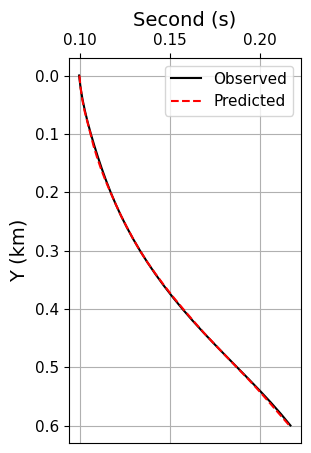

In [ ]:
plt.style.use('default')

plt.figure(figsize=(3,5))

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

ax = plt.gca()
#ax.xaxis.set_tick_params(labeltop='on')

plt.plot(T_data_all[5,:,15,0], y_pred, 'k-')
plt.plot(T_pred[5,:,15,0], y_pred, 'r--')
print(T_pred.shape)

ax.set_title('Second (s)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=11)

# plt.ylim([0,1])
# plt.xlim([1.25,4.5])

plt.gca().invert_yaxis()

plt.legend(['Observed','Predicted'],fontsize=11)

plt.grid()

plt.savefig(f"./{fig_path}/data_fit1.pdf", format='pdf', bbox_inches="tight")